# Data Modeling

## Relational Databases

Benefits of using a relational DB:
- Writing in SQL
- Modeling the data, not queries
- Joining
- Aggregations and analytics
- Secondary indexes available - help with quick searching
- Smaller data volumes
- ACID transactions
- Easier to change to business requirements

When not to use RDBs
- Large amounts of data
- Need fast reads
- Need to store many formats
- Need flexible schema
- Need high availability/distribution (RDBs have a single worker/processor)
- Need horizontal scalability - adding mroe machines/nodes to increase performance

### ACID Transactions

Ensures data integrity

Guarantee validity event when errors or power failures occur!
- Atomicity
  - the whole transaction is processed or nothing at all, i.e. moving money out of checking into savings
- Consistency
  - transactions that follow constraints/rules are written to the DB, otherwise they are not, i.e. not entering ints into a boolean row
- Isolation
  - transactions are processed securely and independently. Order of transactions does not matter
  - Other queries cannot touch data until first is done processing
- Durability
  - completed transactions are saved to DB in case of failure
    - Committed transactions remain committed - effects are recorded in non-volatile storage
    - 

### Playing with PSQL using `psycopg2` lib in Python

In [22]:
import psycopg2
import getpass

In [23]:
user = "postgres"
passwd = getpass.getpass(prompt=f'Enter password for user {user}')
try: 
    conn = psycopg2.connect(f"host=127.0.0.1 dbname=songs user={user} password={passwd}")
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)

In [24]:
try: 
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not get cursor to the Database")
    print(e)

In [25]:
conn.autocommit = True

try: 
    cur.execute("CREATE TABLE IF NOT EXISTS songs (song_title text, artist_name text, year text, album_name text, single bool);")
except psycopg2.Error as e: 
    print("Error: Issue creating table")
    print (e)

In [26]:
try: 
    cur.execute("INSERT INTO songs \
                 VALUES ('Across the Universe', 'The Beatles', 1970, 'Let It Be', False)")
except psycopg2.Error as e: 
    print("Error: Inserting Rows")
    print (e)
    
try: 
    cur.execute("INSERT INTO songs \
                  VALUES ('Think For Yourself', 'The Beatles', 1965, 'Rubber Soul', False)")
except psycopg2.Error as e: 
    print("Error: Inserting Rows")
    print (e)

In [27]:
## TO-DO: Finish the SELECT * Statement 
try: 
    cur.execute("SELECT * FROM songs;")
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

('Across the Universe', 'The Beatles', '1970', 'Let It Be', False)
('Think For Yourself', 'The Beatles', '1965', 'Rubber Soul', False)
('Across the Universe', 'The Beatles', '1970', 'Let It Be', False)
('Think For Yourself', 'The Beatles', '1965', 'Rubber Soul', False)


In [28]:
cur.close()
conn.close()

## NoSQL/NonRelational Databases

MongoDB does support ACID transactions as of v4.2. Otherwise, don't use these if you want ACID transactions, ability to JOIN across tables, or when your dataset is small.

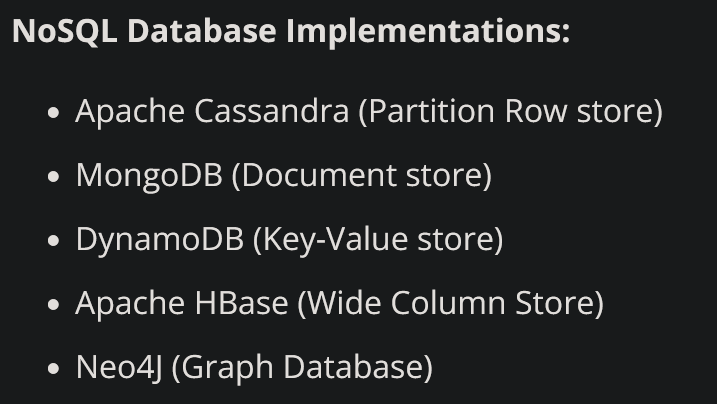

### Apache Cassandra

Partition Row store. See pics below

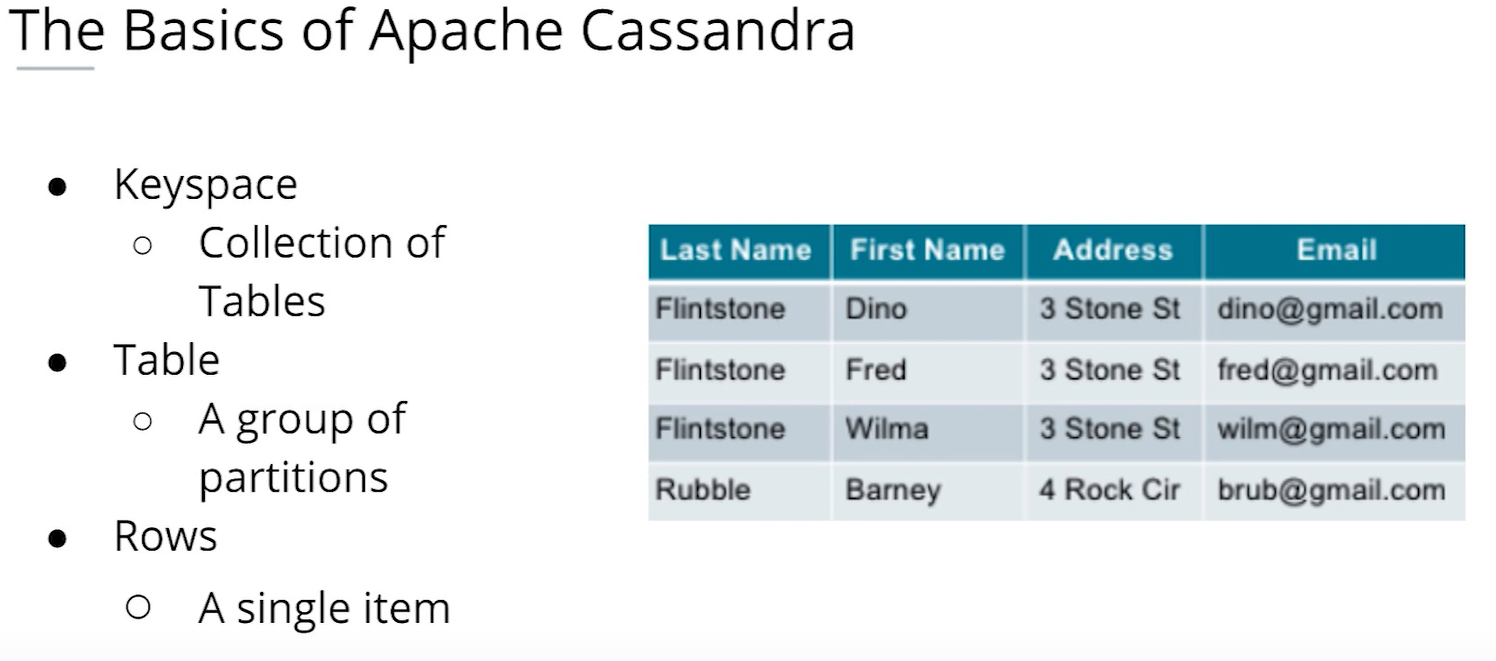

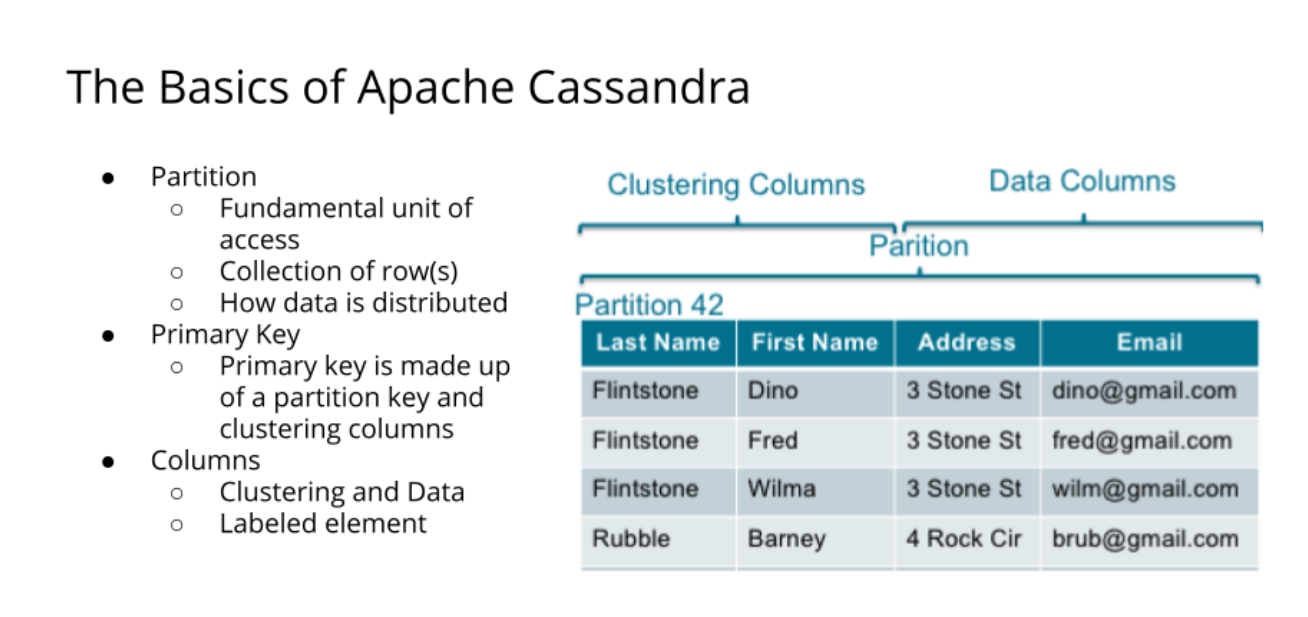

#### But what is it?

- Scalability, high availability, fault tolerance, etc. 
- Uses Cassandra Query Lang
- Great for:
    - Transaction logging
    - IoT
    - Time series data
    - Any workload w/ heavy writes to DB


#### Creating a table with Cassandra

Get the driver with `pip install cassandra-driver`

In [46]:
import cassandra

In [47]:
from cassandra.cluster import Cluster

try:
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
except Exception as e:
    print(e)

Testing the connection

In [48]:
try:
    session.execute("""select * from nonexistent_table""")
except Exception as e:
    print(e)

Error from server: code=2200 [Invalid query] message="No keyspace has been specified. USE a keyspace, or explicitly specify keyspace.tablename"


Create a keyspace to do work in

In [ ]:
try:
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS data_modeling
        WITH REPLICATION = 
            { 'class' : 'SimpleStrategy', 'replication_factor' : 1}
    """)  # for now, just use that replication strat and factor for local instances
except Exception as e:
    print(e)

In [ ]:
try:
    session.set_keyspace('data_modeling')
except Exception as e:
    print(e)

Now we want to create a music library of albums...

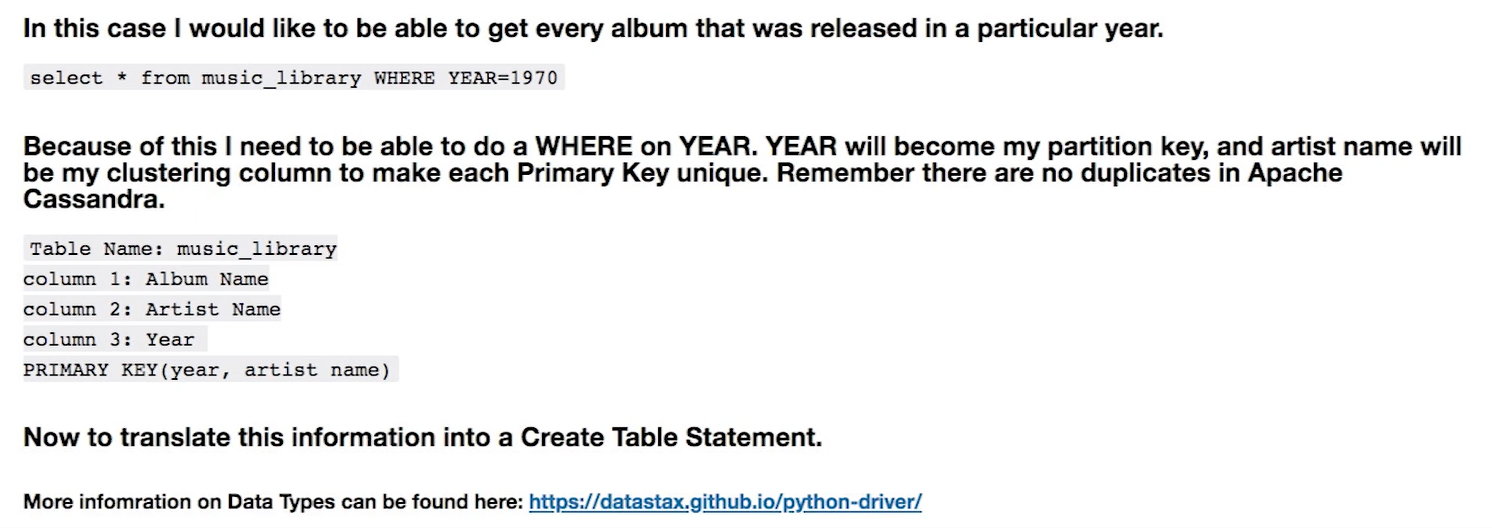

In [44]:
query = "CREATE TABLE IF NOT EXISTS music_library"

# Assuming artists do not release more than 1 album per year
query = query + "(year int, artist_name text, album_name text, PRIMARY KEY (year, artist_name))"

try:
    session.execute(query)
except Exception as e:
    print(e)

In [37]:
query = "select count(*) from music_library"

try:
    count = session.execute(query)
except Exception as e:
    print(e)

print(count.one())

Row(count=0)


Insert two rows...

In [38]:
query = "INSERT INTO music_library (year, artist_name, album_name)"
query = query + " VALUES (%s, %s, %s)"

try:
    session.execute(query, (1970, "The Beatles", "Let it Be"))
    session.execute(query, (1965, "The Beatles", "Rubber Soul"))
except Exception as e:
    print(e)

In [43]:
query = "select * from music_library"  # never do a SELECT * on a prod cassandra system

try:
    rows = session.execute(query)
except Exception as e:
    print(e)

for row in rows:
    print(row.year, row.album_name, row.artist_name)

1965 Rubber Soul The Beatles
1970 Let it Be The Beatles


Close the session and cluster!

In [45]:
session.shutdown()
cluster.shutdown()

## Relational Data Models

### Codd's 12 rules

 https://en.wikipedia.org/wiki/Codd%27s_12_rules

### OLTP vs. OLAP

Remember from Data+?
- OLAP: Aggregation processing - slow, relatively speaking. Ad hoc queries and such. OLAP DBs are optimized for reads
- OLTP: Transaction processing - very very fast. These DBs are optimized for writes. Has very little aggregation, if any

### Normalization and Denormalization

Normalization/Normal forms: remove redundant data + bolster referential integrity

#### Normal Form Objectives:
- Free the DB from unwanted insertions, updates, deletion of dependencies
  - Update in one place
- Reduce refactoring as new types of data are intro'd
  - Add a column or a table with a foreign key, not change and read each row
- Make relational model more informative to users (readable/model real life concepts)
- Make the DB neutral to query stats
  - Not designing for particular queries

- 1NF: Unique and single values, different relations in different tables, keep relations with FKs
- 2NF: All cols rely on PK
- 3NF: 2NF and no transitive dependencies, i.e. you want to be able to get from A->C without going through B

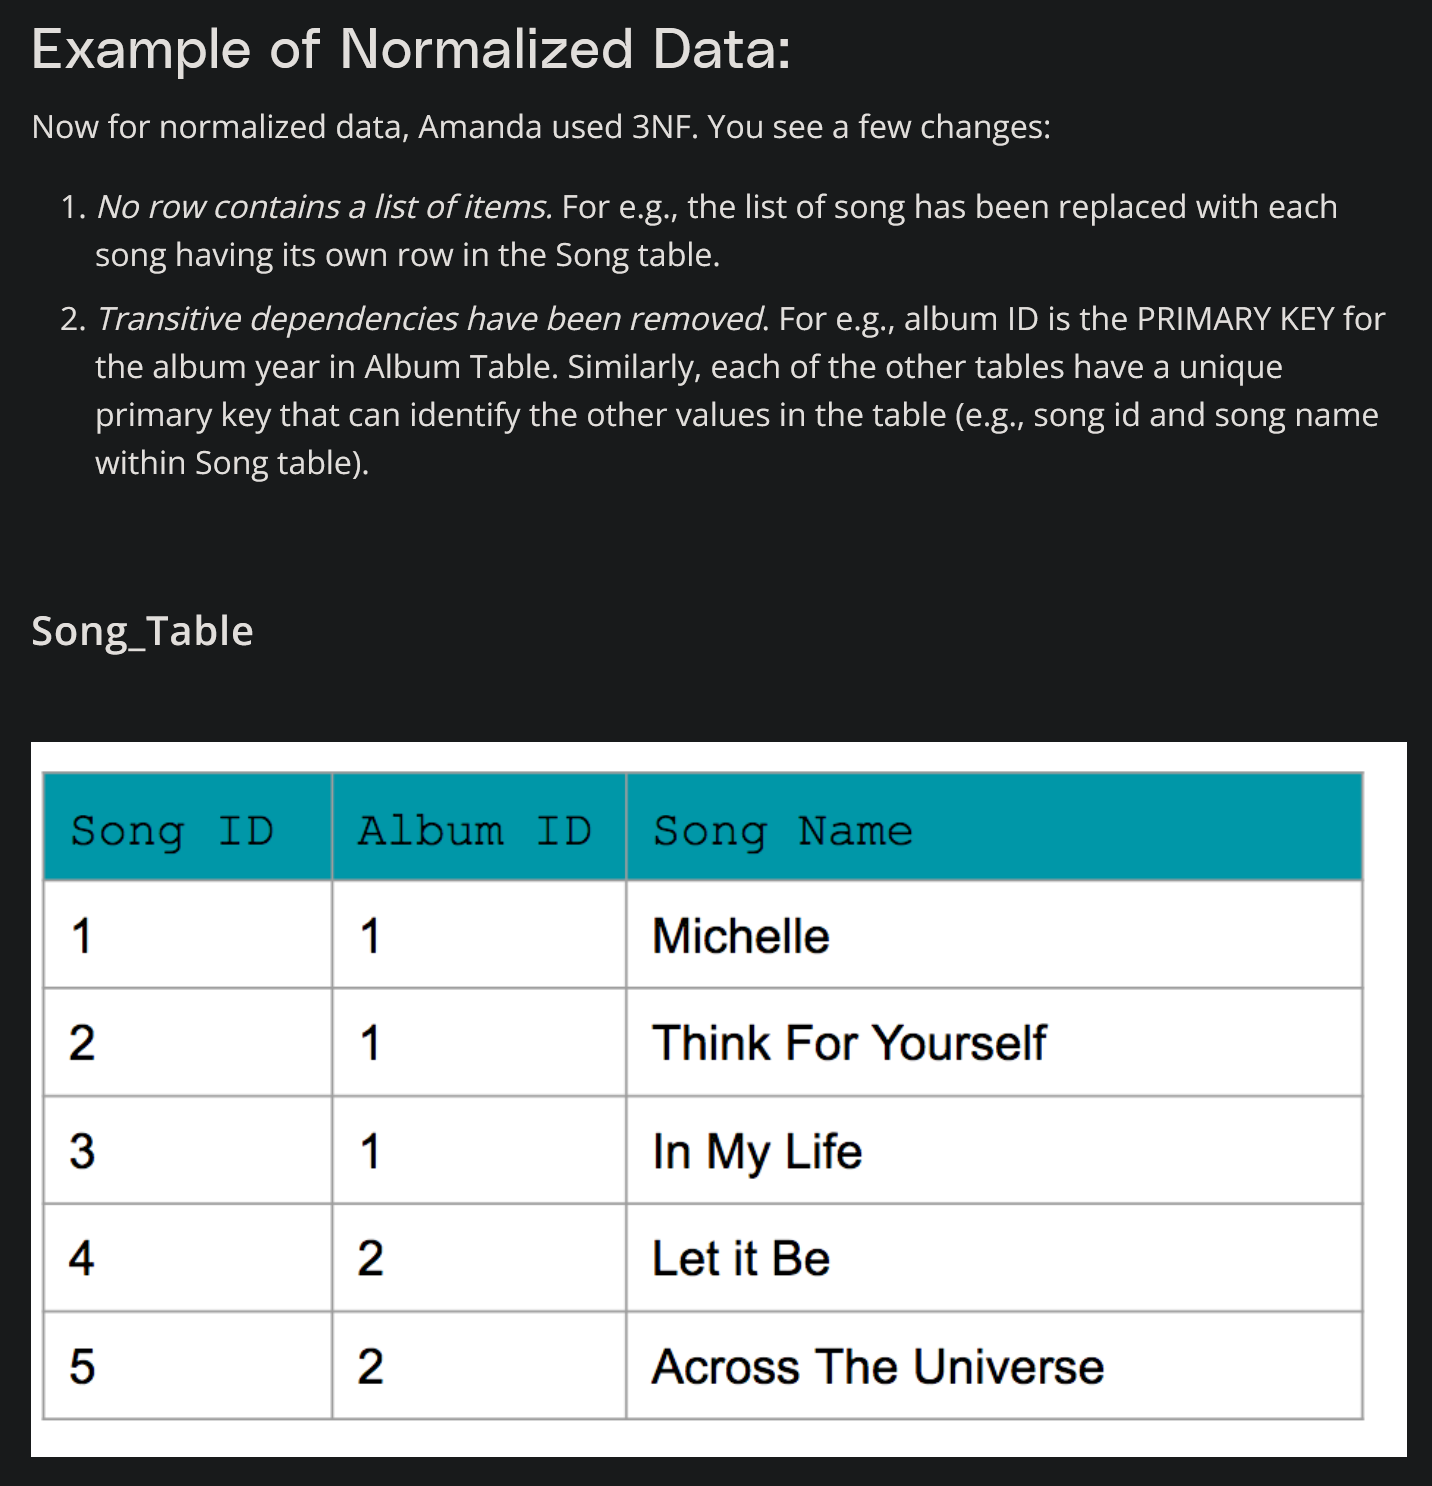

#### Denormalization:
- Tables are more focused on the queries that are ran
- Duplicate copies of data and such, or whatever
- Kind of think of it as expanding out something into plain language instead of a bunch of foreign keys/IDs being referenced.

JOINS are just really freaking slow, so if you find yourself needing to do them often, just denormalize

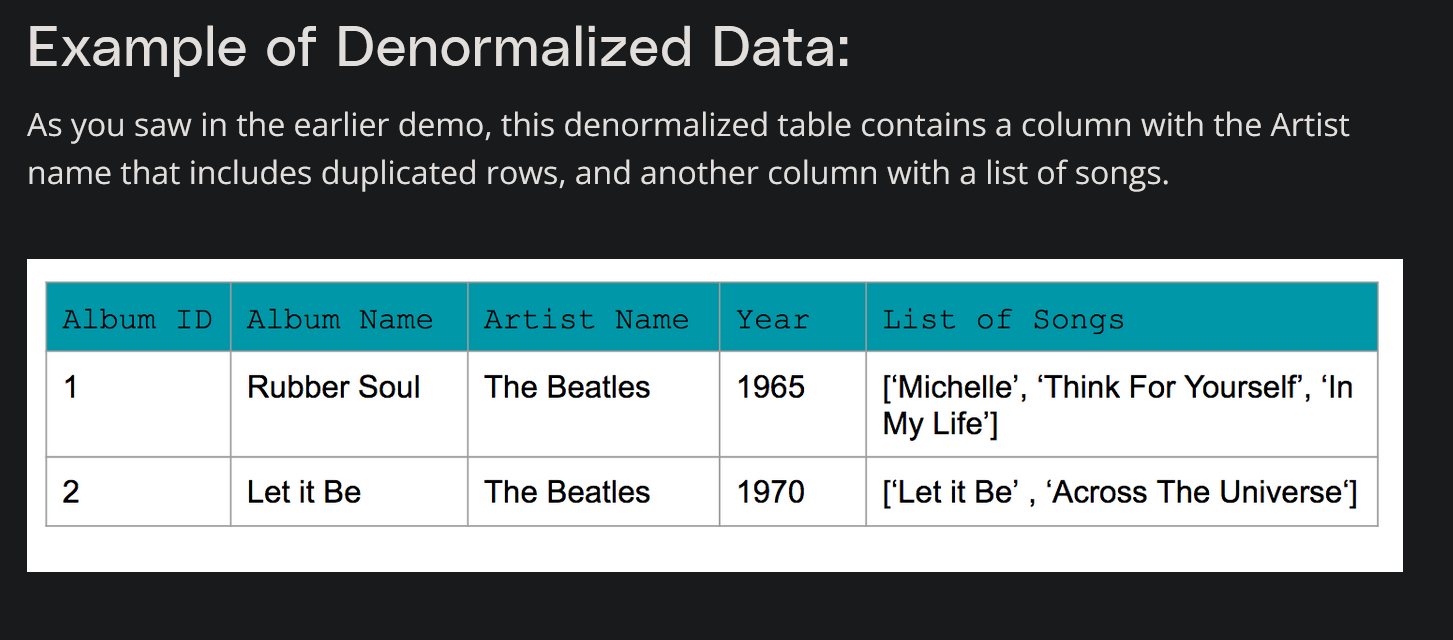

#### Creating Normalized Tables

[Reference this notebook](./lesson-2-demo-1-creating-normalized-tables.ipynb)

#### Creating Denormalized Tables

[Reference this notebook](./lesson-2-demo-2-creating-denormalized-tables.ipynb)

### Fact and Dimension Tables

Dimension tables provide:
- Where was the product bought?
- When was it bought?
- What was bought?

Fact tables provide the metric of the business process
- How much of the product was bought?

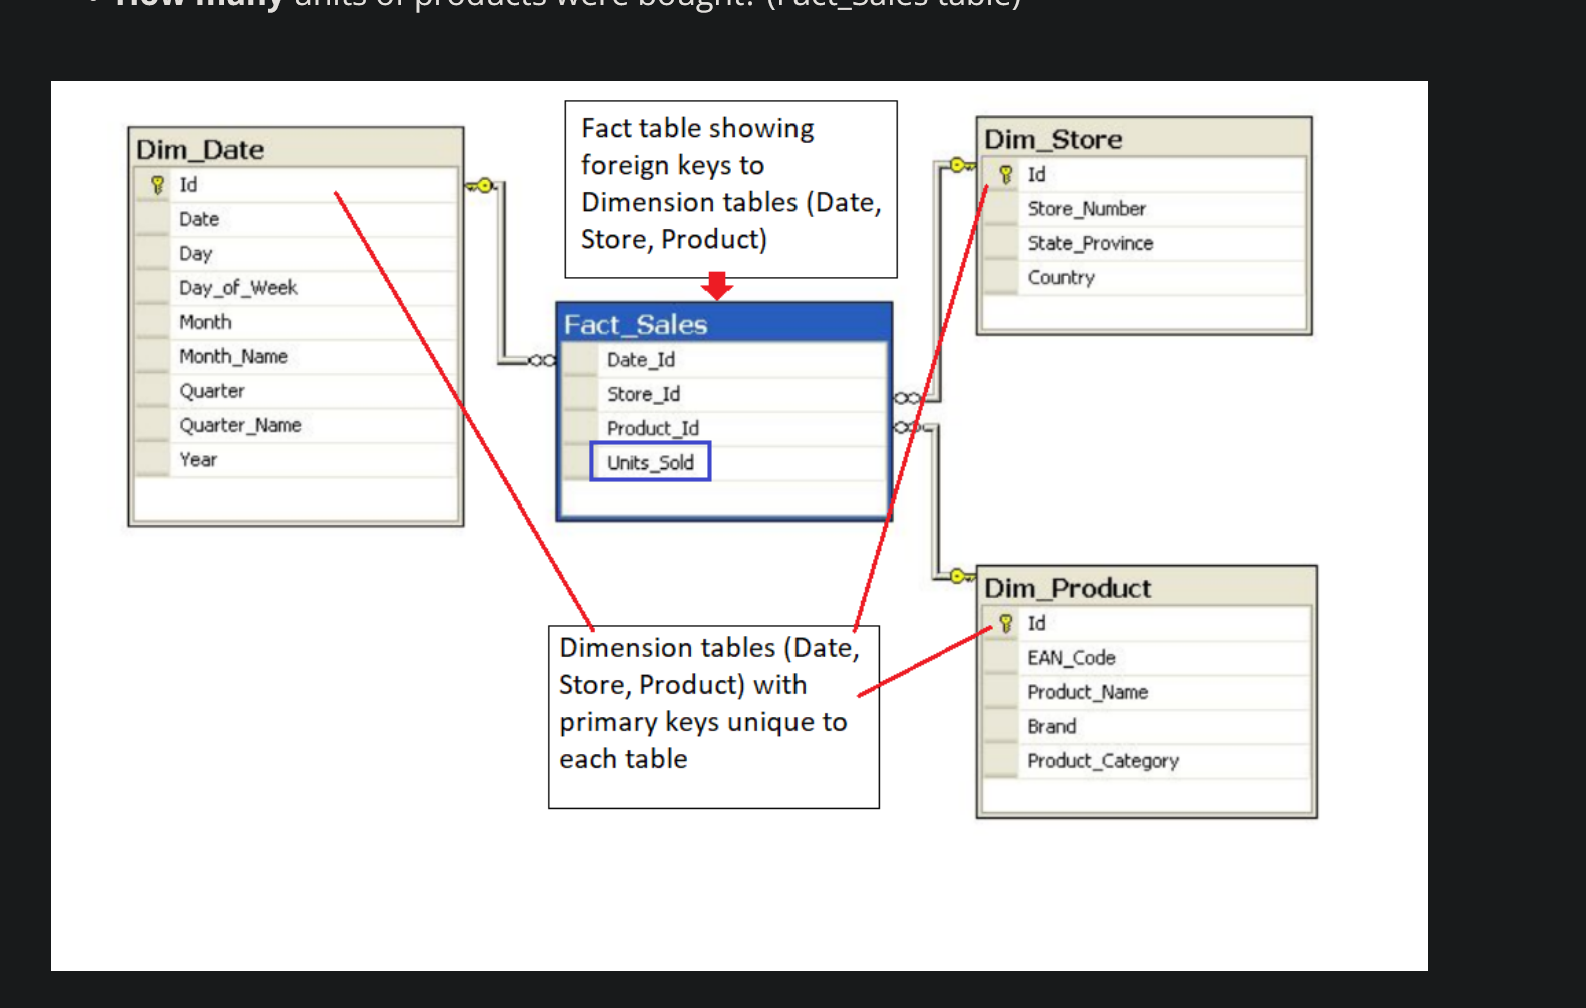

### Star Schemas

Fact table is at the center, Dimension tables surround the table

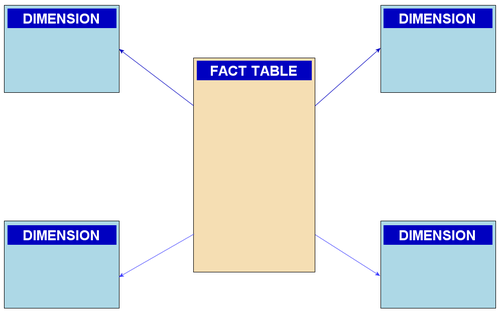

Good because:
- Denormalized
- Simplifies queries
- Fast aggregs

Bad because:
- Issues with denormalized data
- Data integrity
- Decrease query flexibility
- Many to many rels simplified

### Snowflake Schemas

More normalized than star schema, but only in 1 or 2NF

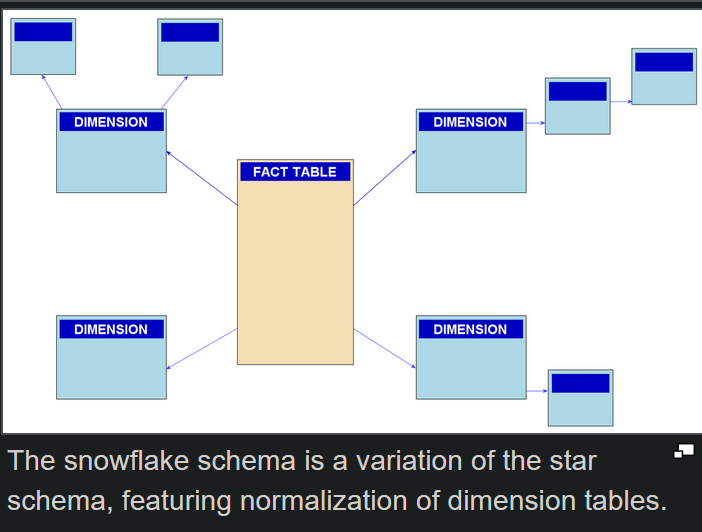

### Data Definition and Constraints

NOT NULL

```sql
CREATE TABLE IF NOT EXISTS customer_transactions (
    customer_id int NOT NULL, 
    store_id int, 
    spent numeric
);
```

Usually composite keys have more than one NOT NULL column

```sql
CREATE TABLE IF NOT EXISTS customer_transactions (
    customer_id int NOT NULL, 
    store_id int NOT NULL, 
    spent numeric
);
```

-----

UNIQUE

```sql
CREATE TABLE IF NOT EXISTS customer_transactions (
    customer_id int NOT NULL UNIQUE, 
    store_id int NOT NULL UNIQUE, 
    spent numeric 
);

CREATE TABLE IF NOT EXISTS customer_transactions (
    customer_id int NOT NULL, 
    store_id int NOT NULL, 
    spent numeric,
    UNIQUE (customer_id, store_id, spent)
);
```

---

PRIMARY KEY

```sql
CREATE TABLE IF NOT EXISTS store (
    store_id int PRIMARY KEY, 
    store_location_city text,
    store_location_state text
);

CREATE TABLE IF NOT EXISTS customer_transactions (
    customer_id int, 
    store_id int, 
    spent numeric,
    PRIMARY KEY (customer_id, store_id)
);  -- composite key

```

### Upsert/Insert

Upsert refers to inserting a new row if it doesn't exist, or updating it if it does. It's a portmanteau

Do this in PostgreSQL with `INSERT` + `ON CONFLICT`

```sql
INSERT INTO customer_address (customer_id, customer_street, customer_city, customer_state)
VALUES
 (
 432, '923 Knox Street', 'Albany', 'NY'
 ) 
ON CONFLICT (customer_id) 
DO NOTHING; 
```